In [69]:
#imports
import spacy
from spacy.lang.en import English
import re
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import sklearn
import string
import pickle
from sklearn.externals import joblib
from spacy.lang.en.stop_words import STOP_WORDS
#from predictors import *

In [73]:
data_consolidated = pd.read_csv('data_consolidated.csv')

data = pd.DataFrame({'headline':data_consolidated['headline'], 'label':data_consolidated['label']}, columns=['headline', 'label'])

corrections = pd.read_csv('headline_errors.csv')

corrections.columns = ['headline', 'corrected_label']

joined = data.join(corrections.set_index('headline'), on='headline')

notnull = joined[['headline','corrected_label']][joined['corrected_label'].notnull()]

notnull.columns = ['headline','label']

data_path = r'../data/output_data/'

df_union = pd.concat([joined[['headline','label']][joined['corrected_label'].isnull()]
                        ,notnull
                        ,pd.read_csv(data_path + 'apple201907200934.csv')
                        ,pd.read_csv(data_path + 'lg201907200951.csv')
                        ,pd.read_csv(data_path + 'stock_news_201907200922.csv')])

df_union = df_union.astype({'label': 'int64'})

In [74]:
df_union.to_csv('data_consolidated.csv')

In [75]:
###SVD dimensionality reduction
from sklearn.decomposition import TruncatedSVD


svd = TruncatedSVD(n_components=100, algorithm='randomized', n_iter=5, random_state=None, tol=0.0)

In [76]:
nlp = English()
spacy_stopwords = STOP_WORDS
punct = string.punctuation

class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    try:
        text = unidecode.unidecode(text)
    except:
        pass
    return text.strip().lower()

def tokenizer_spacy(headline):
        #filtered_tokenized.append(df_union.at[i, 'headline'])
        #filtered_tokenized.append(row)

    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(str(headline))
    
    #lemmatization improved model
    
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop wordsspacy_stopwords
    return [ str(word).lower().strip() for word in mytokens if str(word).lower().strip() not in spacy_stopwords and str(word).lower().strip() not in punct ]

    # return preprocessed list of tokens

In [77]:
bow_vector = CountVectorizer(tokenizer = tokenizer_spacy, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(tokenizer = tokenizer_spacy)

In [78]:
from sklearn.model_selection import train_test_split

X = df_union['headline'] # the features we want to analyze
y = df_union['label'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [79]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x0000018F17088E10>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
      ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [80]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression f1:",metrics.f1_score(y_test, predicted))

Logistic Regression Accuracy: 0.895993413830955
Logistic Regression Precision: 0.914322664080181
Logistic Regression Recall: 0.9612508497620667
Logistic Regression f1: 0.9371996685998343


In [81]:
error_analysis = pd.DataFrame(X_test.copy())
error_analysis['actual_classification'] = y_test
error_analysis['logistic_regression_classification'] = predicted

In [82]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

text = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('selector', svd),
                 ('classifier', clf)])

text.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x0000018F1832C860>), ('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
      ...alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2, silent=None,
       subsample=0.7, verbosity=1))])

In [83]:
predicted = text.predict(X_test)

# Model Accuracy
print("XGBoost Accuracy:",metrics.accuracy_score(y_test, predicted))
print("XGBoost Precision:",metrics.precision_score(y_test, predicted))
print("XGBoost Recall:",metrics.recall_score(y_test, predicted))
print("XGBoost f1:",metrics.f1_score(y_test, predicted))

XGBoost Accuracy: 0.8852908891328211
XGBoost Precision: 0.8948685857321652
XGBoost Recall: 0.9721278042148198
XGBoost f1: 0.9318996415770608


In [53]:
#saving models

joblib.dump(text, 'xgboost_finalized_model.sav')
joblib.dump(pipe, 'logistic_finalized_model.sav')



['logistic_finalized_model.sav']

In [101]:
errors_xg = error_analysis[error_analysis.actual_classification != error_analysis.xgboost_classification]
errors_lr = error_analysis[error_analysis.actual_classification != error_analysis.logistic_regression_classification]

errors = pd.concat([errors_xg,errors_lr]).drop_duplicates()

errors.to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis.csv")

errors_xg[['headline','actual_classification', 'xgboost_classification']].to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis_xgboost.csv")

errors_lr[['headline','actual_classification', 'logistic_regression_classification']].to_csv(r"C:\Users\amber\Documents\VSE\DAEN 690\repo\DAEN-690\data\output_data\error_analysis_lr.csv")

In [102]:
#plot confusion matrices

from sklearn.metrics import confusion_matrix

confusion_matrix(error_analysis['actual_classification'], error_analysis['logistic_regression_classification'])


array([[ 437,  265],
       [ 114, 2828]], dtype=int64)

In [103]:
confusion_matrix(error_analysis['actual_classification'], error_analysis['xgboost_classification'])

array([[ 366,  336],
       [  82, 2860]], dtype=int64)

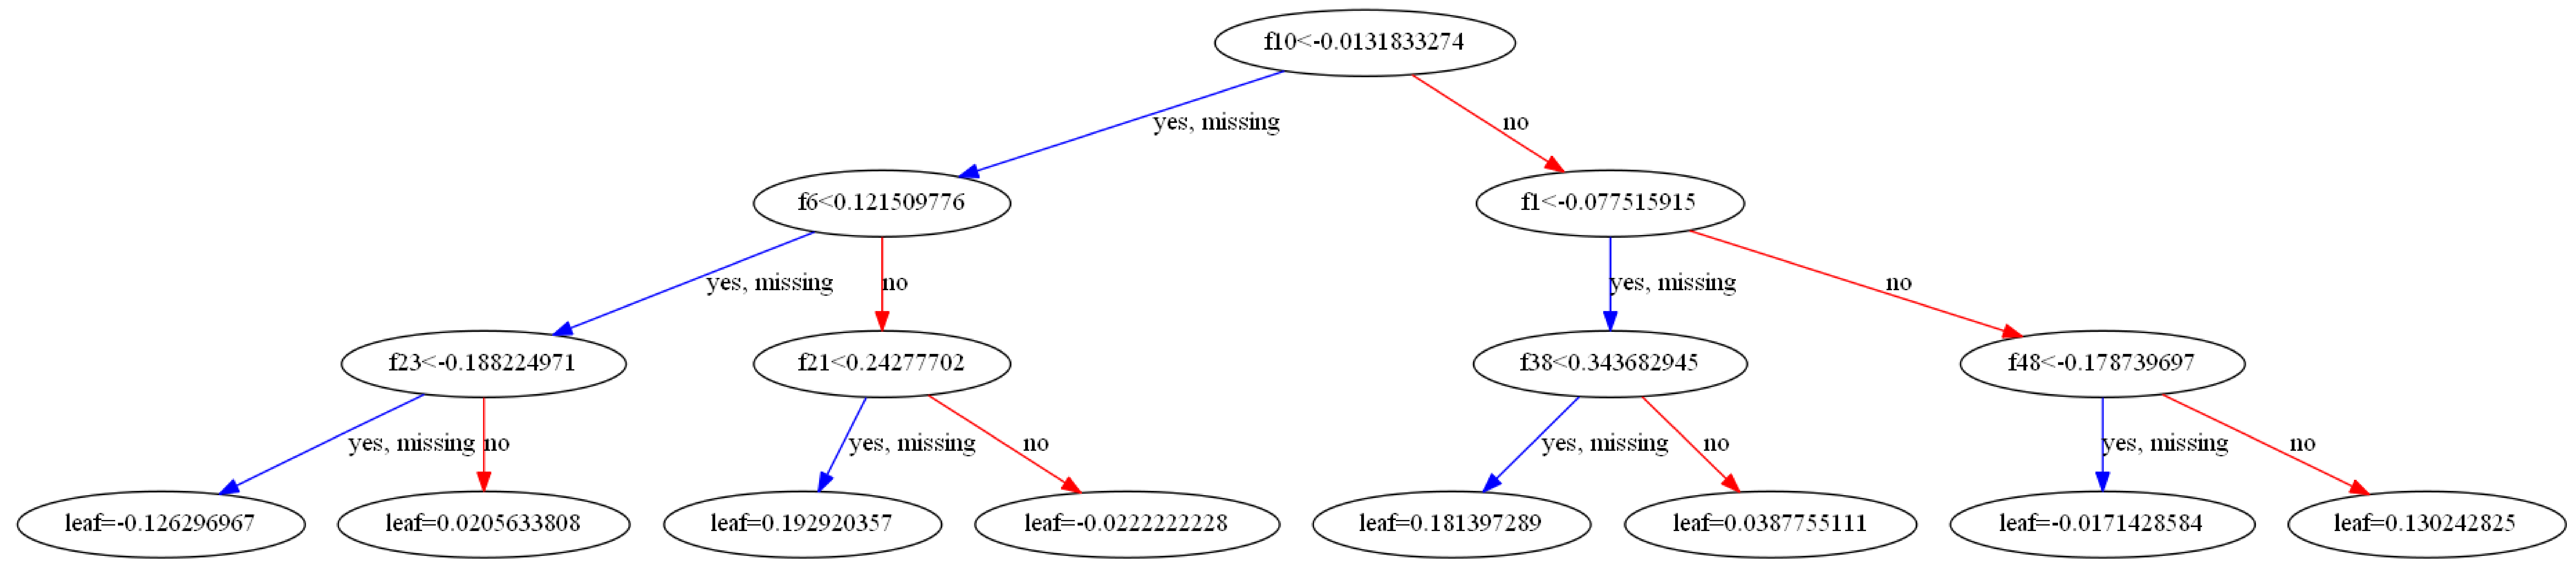

In [104]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
# plot single tree
plot_tree(clf)
fig = plt.gcf()
fig.set_size_inches(150, 150)
fig.savefig('tree.png')